In [1]:
!pip install -U plotly
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 13.2MB 234kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 1.0MB 7.8MB/s 


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as s
import os
import io
import time
import keras

import IPython
import IPython.display

from sklearn import preprocessing, metrics  

from keras.models import Model
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from keras.callbacks import EarlyStopping

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt
import importlib.util
import datetime
import shutil
import os


from google.colab import drive
import sys

%load_ext tensorboard
pd.options.plotting.backend = "plotly"
# np.set_printoptions(threshold=np.inf)
# pd.set_option("display.max_rows", None, "display.max_columns", None)

drive.mount("/content/drive")

np.set_printoptions(threshold=sys.maxsize)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
# inspired by 
# https://machinelearningmastery.com/use-different-batch-sizes-training-predicting-python-keras/
# https://www.tensorflow.org/tutorials/text/text_generation

df = pd.read_pickle("./drive/MyDrive/Colab_Notebooks/bachelor_data/DATA_hourly_inside.pkl")

# test
df.interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
# test

df['q','MARI'].interpolate(method='time', axis=0, limit=None, inplace=True, limit_direction='both')
df.reset_index(inplace= True)
df.columns = [' '.join(col).strip().replace(' ','_') for col in df.columns.values]

n = len(df)
train_n = int(n*0.7)
val_n = int(n*0.9)
times_test = df['TimeStamp'][val_n:]
times_val = df['TimeStamp'][train_n:val_n]

times_s = df['TimeStamp'].map(datetime.datetime.timestamp)
df.drop('TimeStamp', 1, inplace=True)

day = 24*60*60
year = (365.2425)*day

df['yearsin'] = np.sin(times_s * (2 * np.pi / year))
df['yearcos'] = np.cos(times_s * (2 * np.pi / year))

# create train, val and test df

train_df = df[:train_n]
val_df = df[train_n:val_n]
test_df = df[val_n:]

num_features = df.shape[1]
print(num_features)
print(train_df.shape)

# normalize the data
train_mean = train_df.mean()
train_std = train_df.std()

train_df_normal = (train_df - train_mean) / train_std
val_df_normal = (val_df - train_mean) / train_std
test_df_normal = (test_df - train_mean) / train_std

# data filling
fill_value = -7.0

train_df_normal_fill = train_df_normal.fillna(fill_value)
train_df_normal_fill = train_df_normal_fill.astype('float32')

val_df_normal_fill = val_df_normal.fillna(fill_value)
test_df_normal_fill = test_df_normal.fillna(fill_value)
index_q_MARIE = list(df.columns).index('q_MARI')

48
(79615, 48)


In [ ]:
def cread_input_target(raw_data, lookback_window, prediction_window, target_value_index, overlapping ):
  remainder = len(raw_data) % 24
  input = []
  target = []
  target_in = []

  for i in range(0,len(raw_data)- lookback_window- prediction_window, 1 if overlapping else prediction_window):
    
    in1 = np.array(raw_data[i: i+lookback_window]).astype('float32')
    input.append(np.array(raw_data[i: i+lookback_window]).astype('float32'))

    t = np.array(raw_data[i+lookback_window:i+lookback_window+ prediction_window,target_value_index]).astype('float32')
    t = t.reshape(len(t),1)
    t_in = np.concatenate((np.array([[-0.7]]), t[:-1]))
    

    target.append(np.array(t))
    target_in.append(t_in)


  input = np.array(input)
  target = np.array(target)
  target_in = np.array(target_in)


  return input, target_in, target

In [ ]:
lookback_window = 4* 24
prediction_window = 1*24
index_q_MARIE = list(df.columns).index('q_MARI')
BATCH_SIZE = 64

train_np = train_df_normal_fill.to_numpy(dtype='float32')

val_np = val_df_normal_fill.to_numpy()
test_np = test_df_normal_fill.to_numpy()

input_train, target_in_train ,target_train = cread_input_target(train_np, lookback_window,prediction_window,index_q_MARIE, overlapping = True)
input_val,target_in_val ,target_val = cread_input_target(val_np, lookback_window,prediction_window,index_q_MARIE, overlapping = False )
input_test,_ ,target_test  = cread_input_target(test_np, lookback_window,prediction_window,index_q_MARIE, overlapping = False )


In [ ]:
# based on
# https://machinelearningmastery.com/develop-encoder-decoder-model-sequence-sequence-prediction-keras/
# https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
# https://stackoverflow.com/questions/52465971/keras-seq2seq-stacked-layers


# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_output, hparams):
  encoder_layers, decoder_layers = hparams["NRLAYERS"]

  n_units = hparams["NUMUNITS"]
  dropout = hparams["DROPOUT"]

	# define training encoder
  encoder_inputs = Input(shape=(None, n_input))
  if encoder_layers ==2:
    encoder0 = LSTM(n_units, return_sequences=True, return_state=True )
    encoder = LSTM(n_units, return_sequences=False,return_state=True)
    encoder_outputs, _, _ = encoder0(encoder_inputs)
    encoder_outputs, state_h, state_c = encoder(encoder_outputs)
    
  else: 
    encoder = LSTM(n_units, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
  
  # only the states of the last layer are of interest.
  encoder_states = [state_h, state_c]

  # define training decoder
  decoder_inputs = Input(shape=(None, n_output))

  if decoder_layers ==2:
    decoder_lstm0 = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)

    decoder_outputs , h0, c0 = decoder_lstm0( decoder_inputs, initial_state=encoder_states)
    decoder_outputs, _, _ = decoder_lstm(decoder_outputs, initial_state=encoder_states)
  
  else:
    decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)


  decoder_dense = Dense(n_output)
  decoder_outputs = decoder_dense(decoder_outputs)
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  
  # define inference encoder
  encoder_model = Model(encoder_inputs, encoder_states)

  # define inference decoder
  if decoder_layers ==2:
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_state_input_h0 = Input(shape=(n_units,))
    decoder_state_input_c0 = Input(shape=(n_units,))

    decoder_outputs, state_h0, state_c0 = decoder_lstm0(decoder_inputs, 
                                                        initial_state=[decoder_state_input_h0,decoder_state_input_c0])
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_outputs, 
                                                     initial_state=[decoder_state_input_h, decoder_state_input_c])
    
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        inputs= [decoder_inputs] + [decoder_state_input_h0,decoder_state_input_c0,
                                    decoder_state_input_h, decoder_state_input_c],
        outputs = [decoder_outputs] + [state_h0, state_c0, state_h, state_c]
    )

  else:
    decoder_state_input_h = Input(shape=(n_units,))
    decoder_state_input_c = Input(shape=(n_units,))
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, 
                                                     initial_state=[decoder_state_input_h, decoder_state_input_c])
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]


    decoder_states = [ state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = Model([decoder_inputs] + decoder_states_inputs, 
                          [decoder_outputs] + decoder_states)
  
  # return all models
  return model, encoder_model, decoder_model




In [ ]:
# generate target given source sequence
def predict_sequence(infenc, infdec, source, n_steps, cardinality, hparams):
  # tf.keras.utils.plot_model(infenc, to_file="infenc_gru.png", show_shapes=True, show_layer_names=False)
  # tf.keras.utils.plot_model(infdec, to_file="infdec_gru.png", show_shapes=True, show_layer_names=False)

  unit = hparams['UNIT']
  encoder_layers, decoder_layers = hparams["NRLAYERS"]

  state = infenc.predict(source)
  if decoder_layers ==2:
    state = state + state

  target_seq = np.array([0.0 for _ in range(cardinality)]).reshape(1, 1, cardinality)
  output = list()
  
  for t in range(n_steps):

    if decoder_layers ==2:
      yhat, h0, c0, h, c = infdec.predict([target_seq] + state)
      state = [h0, c0, h, c]
    else:
      yhat, h, c = infdec.predict([target_seq] + state)
      state = [h, c]

    output.append(yhat[0,0,:])
    target_seq = yhat

  return np.array(output)

In [12]:
# abc

def pick_median(arg_tensor):
    the_upper_tensor = tf.contrib.distributions.percentile(arg_tensor, 50, interpolation='higher')
    the_lower_tensor = tf.contrib.distributions.percentile(arg_tensor, 50, interpolation='lower')

    final_tensor = (the_upper_tensor + the_lower_tensor) / 2
    # print(the_count.eval(session=keras.backend.get_session()))

    return final_tensor

def maxe(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  return  K.max(y_pred- y_true)


def mae(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  return  pick_median(K.abs(y_pred- y_true))

def rev(y_true, y_pred):
    if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
    y_true = K.cast(y_true, y_pred.dtype)
    return (K.sum(y_pred) - K.sum(y_true)) / K.sum(y_true) * 100


def nse(y_true, y_pred):
  if not tf.is_tensor(y_pred):
        y_pred = K.constant(y_pred)
  y_true = K.cast(y_true, y_pred.dtype)
  
  return 1 - (K.sum((y_pred - y_true) ** 2) / K.sum((y_true - K.mean(y_true))**2))



def get_metrics():
  rmse =  tf.keras.metrics.RootMeanSquaredError()
  meae = tf.keras.metrics.MeanAbsoluteError()
  return [rmse, nse,  meae, maxe, rev]

def get_metric_names():
   return ["rmse", "nse",  "meae", "maxe", "rev"]


def compute_metrics(ys, yhats):

  return {
    "maxe" : maxe(ys, yhats).numpy(),
    "rev"  : rev(ys, yhats).numpy(),
    "nse" : nse(ys, yhats).numpy(),
    "mse" : tf.keras.losses.mean_squared_error(ys, yhats).numpy(),
    "rmse" :  tf.math.sqrt( tf.keras.losses.mean_squared_error(ys, yhats)).numpy(),
    "meae" : tf.keras.losses.MeanAbsoluteError()(ys, yhats).numpy()
}

In [ ]:
def get_callbacks(model_path):
  # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, mode='min')
  checkpoint = ModelCheckpoint(filepath= os.path.join(model_path, "weights/"),
                              monitor='loss', verbose=1, save_best_only=True)
  
  epoch_dots = tfdocs.modeling.EpochDots()
  # term_on_nan = tf.keras.callbacks.TerminateOnNaN()
  log_metrics = tf.keras.callbacks.TensorBoard(model_path)
  # es = EarlyStopping(monitor='val_loss', mode='min', verbose=1 ,  patience=3)

  # log_hparams = hp.KerasCallback(model_path, hparams)

  return [epoch_dots, log_metrics]

In [ ]:
def compile_and_fit(n_features_in, n_features_out, hparams, run_path):
  # define model
  train, infenc, infdec = define_models(n_features_in, n_features_out, hparams)


  train.compile(optimizer=tf.optimizers.Adam(learning_rate=hparams["LEARNINGRATE"]), 
                loss='mse',  
                metrics=get_metrics())
  
  tf.keras.utils.plot_model(train, to_file="train.png", show_shapes=True, show_layer_names=False)
  tf.keras.utils.plot_model(infenc, to_file="infenc.png", show_shapes=True, show_layer_names=False)
  tf.keras.utils.plot_model(infdec, to_file="infdec.png", show_shapes=True, show_layer_names=False)


  history = train.fit([input_train, target_in_train], target_train, 
          epochs= hparams["EPOCHS"], 
          validation_data = ([input_val, target_in_val], target_val),
          batch_size=hparams["BATCHSIZE"],
          callbacks= get_callbacks(run_path))

  return train, infenc, infdec, history



In [ ]:
for i in range(6):
  print(int((i/6)*100) // 25 )

0
0
1
2
2
3


In [ ]:
def evaluate_model(infenc, infdec, input,target, hparams):
  ys = []
  yhats = []

  # input_val,target_in_val ,target_val
  n = len(input)
  i = 0

  for inpt, targ in zip(input, target):
    inpt = inpt.reshape(1,input.shape[1],48 )
    prediction = predict_sequence(infenc, infdec, inpt, target.shape[1], 1, hparams)
    ys = np.concatenate([ys, targ.flatten()])
    yhats = np.concatenate([yhats, prediction.flatten()])
    i = i+1
  return ys,yhats

In [ ]:
# configure problem
n_features_in = 48
n_features_out = 1

n_steps_in = 96
n_steps_out = 24

num_units = 256
dropouts = 0.0
learning_rate = 1e-06
unit = "LSTM"
epochs = 30
batch_size = 128
nr_layers = (2,1)
dropout = 0.0

hparams = {
      "NUMUNITS": num_units, 
      "DROPOUT": dropout, 
      "LEARNINGRATE": learning_rate, 
      "BATCHSIZE": batch_size,
      "NRLAYERS": nr_layers, 
      "UNIT": unit, # not doable
      "EPOCHS": epochs
      }

model_folder = "./drive/MyDrive/Colab_Notebooks/bachelor_models/encoder_decoder/evaluation/nrlayers/"
model_name = "NUMUNITS=256_DROPOUT=0.0_LEARNINGRATE=1e-06_BATCHSIZE=128_NRLAYERS=(2, 1)_UNIT=LSTM_EPOCHS=30"
model_path = os.path.join(model_folder, model_name)
 
trained_model = keras.models.load_model(model_path, custom_objects = {"nse": nse,  
                                                        "mae":mae, 
                                                        "maxe":maxe, 
                                                        "rev": rev})
  
train_test , infenc_test, infdec_test = define_models(n_features_in, n_features_out, hparams)
train_test.set_weights(trained_model.get_weights())

In [ ]:
lookback_windows = [int(i*24) for i in [4,7,14]]
prediction_windows = [int(i*24) for i in [0.5,1,4]]

windowLengths = [(i,j) for i in lookback_windows for j in prediction_windows]
windowLengths

[(96, 12),
 (96, 24),
 (96, 96),
 (168, 12),
 (168, 24),
 (168, 96),
 (336, 12),
 (336, 24),
 (336, 96)]

In [ ]:
lookback_windows = [int(i*24) for i in [4,7,14]]
prediction_windows = [int(i*24) for i in [0.5,1,4]]

windowLengths = [(i,j) for i in lookback_windows for j in prediction_windows]

results= {}

for lbw, pw in windowLengths:
  print(f'{lbw}_{pw}')
  input_test,_ ,target_test  = cread_input_target(test_np, lbw,pw,index_q_MARIE, overlapping = False )
  ys, yhats = evaluate_model(infenc_test, infdec_test, input_test, target_test,hparams )

  r_df = pd.DataFrame({"ys":ys, "yhats":yhats })
  r_df = (r_df * train_std['q_MARI'])+train_mean['q_MARI']
  r_df.to_pickle(f'{lbw}_{pw}.pkl')
  results[f'{lbw}_{pw}'] = [ys, yhats]




96_12
96_24
96_96
168_12
168_24
168_96
336_12
336_24
336_96


In [ ]:
my_results_df = pd.DataFrame(results)
my_results_df.to_pickle("window_results.pkl")

In [15]:
1

1

In [ ]:
df7 = pd.DataFrame()
for k,v in results.items():
  lbw, pdw =[ int(s) for s in k.split("_")]
  df7[k] = pd.Series(v[1][336-lbw:]).head(10944)
  df7["ys"] = pd.Series(v[0])[336-lbw:].head(10944)

df7 = (df7 * train_std['q_MARI'])+train_mean['q_MARI']
df7.index = times_test[336:].head(10944)
df7.plot()
df7.to_pickle("window_results_cleaned.pkl")

In [14]:
my_df7 = pd.read_pickle("96_24.pkl")
my_df7.index = times_test[4*24:-22]
my_df7.rename(columns={'ys': 'true', 'yhats': 'predicted'}, inplace=True)

my_df7.plot(  y = ["true","predicted"], labels={
                     "value": "discharge in [m^3/s] ",
                     "TimeStamp": "time in hours"}
                ,  width=2*500,
                      height=500)

In [16]:
my_df7.to_pickle("encdec_results.pkl")

In [13]:
compute_metrics(my_df7["true"], my_df7["predicted"])

{'maxe': 34.893227,
 'meae': 3.065946578979492,
 'mse': 21.38450719165979,
 'nse': 0.94566894,
 'rev': 6.2493043,
 'rmse': 4.624338568018111}

In [ ]:
my_df7.plot()

In [ ]:
metrics_df7 =  pd.DataFrame(columns=['maxe','meae','mse','nse','rev','rmse'])
for c in df7.columns:
  if c == "ys":
    continue
  metrics_df7.loc[c] = pd.Series(compute_metrics(df7["ys"], df7[c]))

metrics_df7.sort_values("nse",ascending=False)

,maxe,meae,mse,nse,rev,rmse
96_12,36.283920,2.758432,15.231427,0.960738,5.470792,3.902746
168_12,36.284012,2.758433,15.231489,0.960738,5.470792,3.902754
336_12,36.284012,2.758433,15.231489,0.960738,5.470801,3.902754
96_24,31.782837,3.006016,18.911528,0.951252,6.419189,4.348739
168_24,31.782814,3.006018,18.911723,0.951252,6.419244,4.348761
336_24,31.782822,3.006018,18.911724,0.951252,6.419244,4.348761
96_96,59.919155,7.324504,173.846975,0.551878,11.304706,13.185104
336_96,51.372681,7.756492,202.450646,0.478147,6.974687,14.228515
168_96,110.019775,7.836969,219.782444,0.433471,10.644011,14.825061


In [ ]:
result_df2 = pd.DataFrame({"ys":ys, "yhats":yhats })
result_df2 = (result_df2 * train_std['q_MARI'])+train_mean['q_MARI']
result_df2.index = times_test[4*24:-22]
result_df2.to_pickle("optimalModel_lbw64_pw24.pkl")
result_df2

In [ ]:
result_df = pd.DataFrame({"ys":ys, "yhats":yhats })
result_df = (result_df * train_std['q_MARI'])+train_mean['q_MARI']
result_df.index = times_test[4*24:-22]

result_df

,ys,yhats
TimeStamp,,
2016-09-19 02:00:00,145.000003,124.174311
2016-09-19 03:00:00,136.999997,122.297294
2016-09-19 04:00:00,128.999999,120.279093
2016-09-19 05:00:00,122.999998,118.675733
2016-09-19 06:00:00,116.999997,117.353254
...,...,...
2017-12-31 21:00:00,101.000000,64.098483
2017-12-31 22:00:00,107.000001,64.850049
2017-12-31 23:00:00,113.999997,65.562208


In [ ]:
result_df.plot()

In [ ]:
compute_metrics(ys, yhats)

{'maxe': 1.1594597,
 'meae': 0.10187769681215286,
 'mse': 0.023611761223996674,
 'nse': 0.94566894,
 'rev': -35.324543,
 'rmse': 0.15366118971294174}

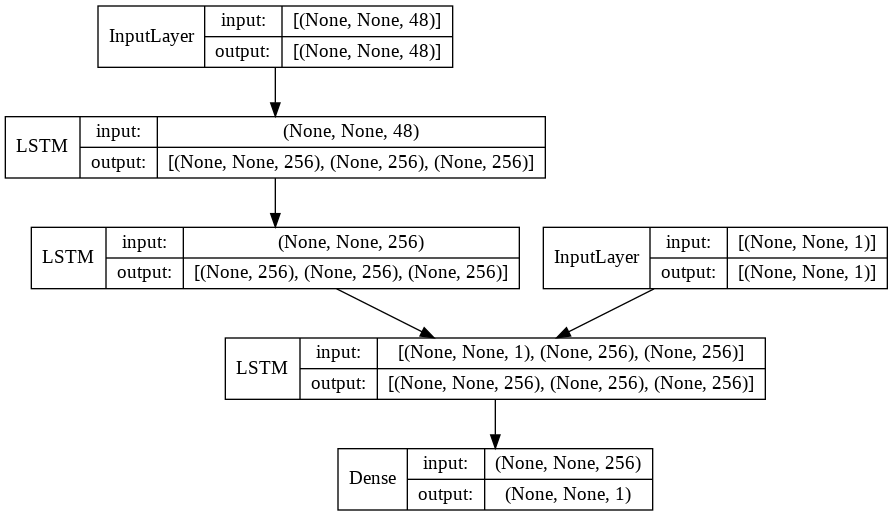

In [ ]:
tf.keras.utils.plot_model(trained_model, to_file="trained_model.png", show_shapes=True, show_layer_names=False)
tf.keras.utils.plot_model(train_test, to_file="train_val.png", show_shapes=True, show_layer_names=False)